<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Field_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Hardware

This Jupyter notebook provides some examples of magentic fields produced by simple loops of wire to better understand MRI hardware. The examples are highly simplified and don't represent actual MRI hardware design. Each code cell can be run by clicking on the upper left corner. You can also run all by using the "Runtime" menu on the top menu bar.

# Objectives
* Understand the basic principles of hardware for B0, Gradients, and RF
* Explore variations on design parameters


In python you need to load libraries to use them. This first cell imports a couple of key libraries and also install latex for other processing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended > 2&>1install_log.txt

# Simple Biot–Savart simulation
Given an loop of wire and current going through the wire, Biot-Savart provides an estimation of the produced magnetic field. Biot-Savart assumes the fields are static but it's a reasonable aproximation for B0 and gradients. At high frequencies, this breaks down and we need to consider wave propogation. Below defines a class that allows us to add elements. It also defines some plotting tools to show the generated field.

In [2]:
# Simple Biosavart using discrete sum of striaight elements
class BSmag:
  def __init__(self):
    self.filament = []

  def add_filament(self, Gamma, I):
    element = {'Gamma': Gamma, 'I': I}
    self.filament.append(element)

  def get_B(self, X, Y, Z):
    mu0 = 4 * np.pi * 1e-7

    BX = np.zeros_like(X)
    BY = np.zeros_like(Y)
    BZ = np.zeros_like(Z)

    for element in self.filament:

      # decompose dictionary
      Gamma = element['Gamma']
      I = element['I']

      for i in range(len(Gamma) - 1):

        x_M = X
        y_M = Y
        z_M = Z

        PkM3 = ((x_M - Gamma[i, 0]) ** 2 + (y_M - Gamma[i, 1]) ** 2 + (z_M - Gamma[i, 2]) ** 2) ** (3 / 2) + 1e-30
        DBx = ((Gamma[i + 1, 1] - Gamma[i, 1]) * (z_M - Gamma[i, 2]) - (Gamma[i + 1, 2] - Gamma[i, 2]) * (y_M - Gamma[i, 1])) / PkM3
        DBy = ((Gamma[i + 1, 2] - Gamma[i, 2]) * (x_M - Gamma[i, 0]) - (Gamma[i + 1, 0] - Gamma[i, 0]) * (z_M - Gamma[i, 2])) / PkM3
        DBz = ((Gamma[i + 1, 0] - Gamma[i, 0]) * (y_M - Gamma[i, 1]) - (Gamma[i + 1, 1] - Gamma[i, 1]) * (x_M - Gamma[i, 0])) / PkM3

        BX += mu0 * I / (4 * np.pi) * (DBx)
        BY += mu0 * I / (4 * np.pi) * (DBy)
        BZ += mu0 * I / (4 * np.pi) * (DBz)

    BX = np.nan_to_num(BX, nan=0)
    BY = np.nan_to_num(BY, nan=0)
    BZ = np.nan_to_num(BZ, nan=0)

    return X, Y, Z, BX, BY, BZ


# Plotting functions
This defines:
*   plot_coils - simple code to plot the loops of wire used to create magnetic feilds
*   field_plot - code to plot the field produced by those coils


In [3]:

def plot_coils(filaments):

  plt.rcParams['text.usetex'] = True
  plt.rcParams.update({'font.size': 14})

  # Quiver plot of z component
  fig = plt.figure(figsize=(10,6))
  ax = plt.axes(projection='3d')
  for filament in filaments:
    xline = filament['Gamma'][:,0]
    yline = filament['Gamma'][:,1]
    zline = filament['Gamma'][:,2]
    ax.plot3D(xline, yline, zline, 'gray')

  [zplane, xplane] = np.meshgrid(np.linspace(-0.5,0.5,25), np.linspace(-0.5,0.5,25))
  yplane = np.zeros_like(xplane)
  ax.plot_surface(xplane, yplane, zplane, color='b',alpha=0.1)

  ax.set_xlabel('$X [m]$')
  ax.set_ylabel('$Y [m]$')
  ax.set_zlabel('$Z [m]$')
  ax.set_box_aspect(aspect=None, zoom=0.8)

  ax.set_xlim([-0.5, 0.5])
  ax.set_ylim([-0.5, 0.5])
  ax.set_zlim([-0.5, 0.5])

  plt.show()


# Standardized plotting
def field_plot(X_M, Y_M, Z_M, BX, BY, BZ):

  # Slice the 3D arrays
  pos = BZ.shape[0]//2
  X = np.squeeze(Z_M[pos,:,:])
  Y = np.squeeze(X_M[pos,:,:])
  U = np.squeeze(BZ[pos,:,:])
  V = np.squeeze(BX[pos,:,:])

  plt.rcParams['text.usetex'] = True
  plt.rcParams.update({'font.size': 22})

  # Generate a stream plot
  plt.figure()
  plt.streamplot(X,Y,U,V,density=2, linewidth=1, arrowsize=1, arrowstyle='->')
  plt.xlabel('$Z [m]$')
  plt.ylabel('$X [m]$')
  plt.show()

  # Create a image plot  plot
  plt.figure(figsize=(10,6))
  plt.imshow(U, cmap='viridis', extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
  plt.colorbar(label='$B_z [T]$')
  plt.xlabel('$Z [m]$')
  plt.ylabel('$X [m]$')
  plt.show()

  plt.figure()
  center = X.shape[0] // 2

  B_center = U[center,:]
  X_center = X[center,:]
  max_index = np.argmax(B_center)
  max_value = B_center[max_index]
  min_value = np.min(B_center)

  plt.plot(X[center,:], U[center,:])
  plt.annotate('{:.2e}'.format(max_value), xy=(X_center[max_index], B_center[max_index]),
             xytext=(X_center[max_index], 1.15*B_center[max_index]),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
  plt.xlabel('$Z [m]$')
  plt.ylabel('$B_z [T]$')
  plt.xlim([np.min(X), np.max(X)])
  plt.ylim([min(1.3*min_value,0), 1.3*max_value])
  plt.show()

  plt.figure()
  center = X.shape[1] // 2

  B_center = U[:, center]
  X_center = Y[:, center]
  max_index = np.argmax(B_center)
  max_value = B_center[max_index]
  min_value = np.min(B_center)

  plt.plot(Y[:, center], U[:, center])
  plt.annotate('{:.2e}'.format(max_value), xy=(X_center[max_index], B_center[max_index]),
             xytext=(X_center[max_index], 1.15*B_center[max_index]),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
  plt.xlabel('$X [m]$')
  plt.ylabel('$B_z [T]$')
  plt.xlim([np.min(Y), np.max(Y)])
  plt.ylim([min(1.3*min_value,0), 1.3*max_value])
  plt.show()

# Creating $B_0$ and $G_z$ using loops of wire

To create $G_z$ and $B_0$ fields we will use loops of circular wire along the bore. For this simulation, we are assuming the coils have current but no leads to coils themselves. The main parameters we can control here are:


*   *loops* - The number of loops along z
*   *bore_radius* - The radius of the bore. This would be the position of the wires in the superconducting bath for $B_0$ and would be ~0.4m. For a $G_z$ gradient, the would need to be inside the cold bore and would be less than the bore diamaeter.
*   *loop_coverage* - The length in which the coils are placed
*   *loop_current_start* - The current in the 1st loop
*   *loop_current_end* - The current in the last loop. The current changes linearly from the 1st to last coil.



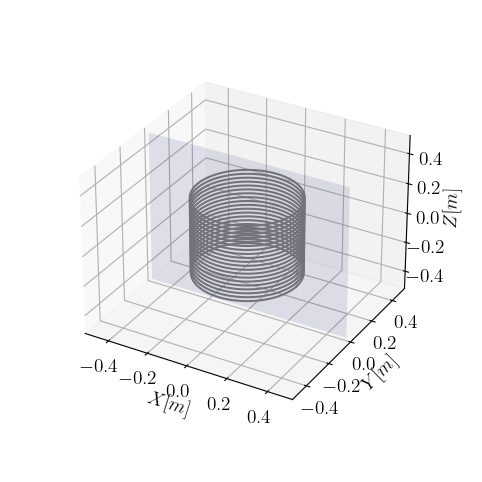

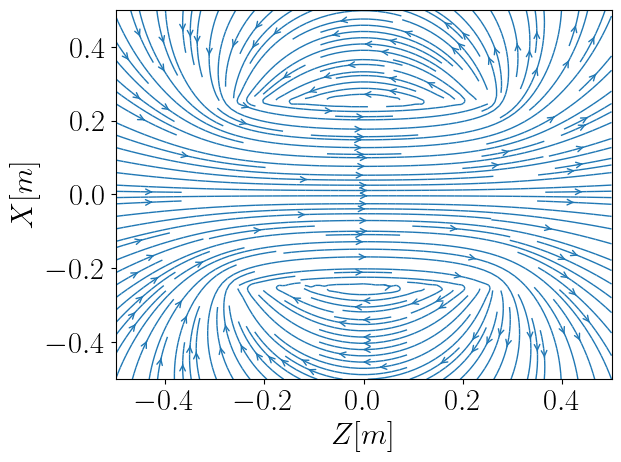

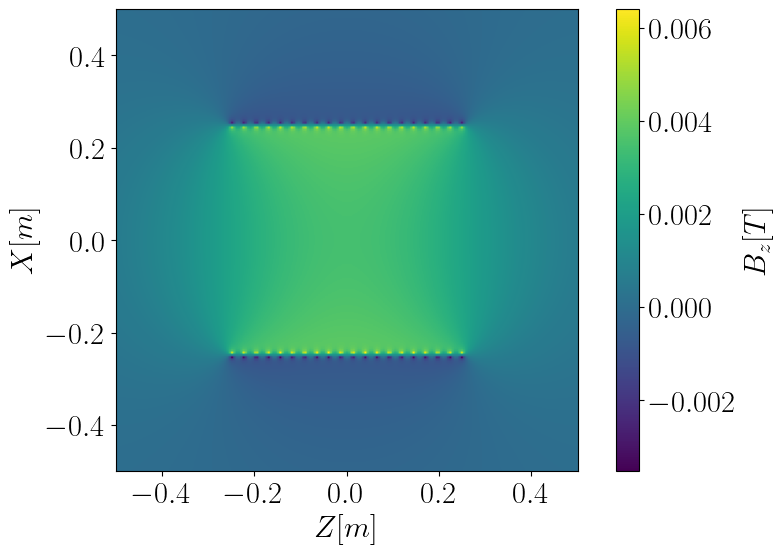

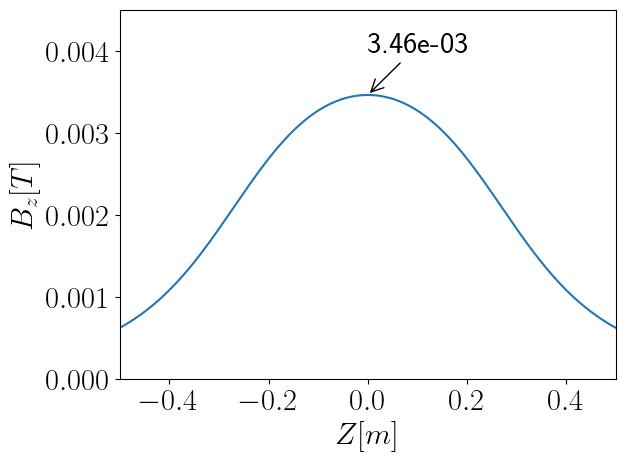

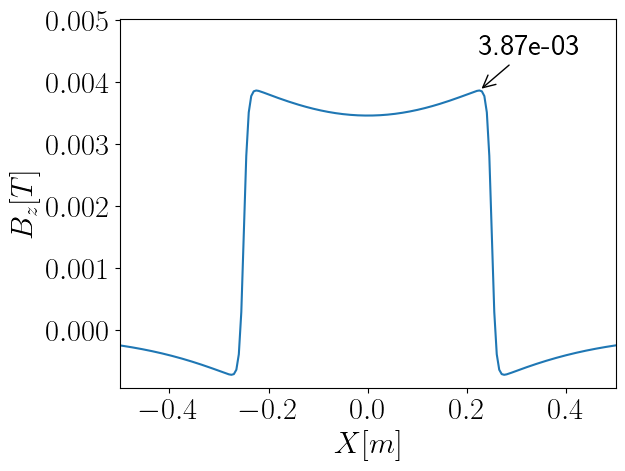

In [4]:
'''
   Variables to change
'''
loops = 20 # Number of loops
bore_radius = 0.25 # Diameter of the bore
loop_coverage = 0.5 # Spacing along z
loop_current_start = 100 # amps at the first loop
loop_current_end = 100 # amps at the last loop

# Create the coils
if loops == 1:
  loop_positions = [0,]
  loop_current = [loop_current_start,]
else:
  loop_positions = np.linspace(-loop_coverage/2, loop_coverage/2, loops)
  loop_current =  np.linspace(loop_current_start, loop_current_end, loops)

# Initialize class which will accumulate coils
bs_mag = BSmag()

# Source points
for z, current in zip(loop_positions, loop_current):
  theta = np.linspace(0, 2*np.pi, 2 * 100)
  Gamma = np.column_stack([bore_radius*np.cos(theta), bore_radius*np.sin(theta), np.ones_like(theta)*z])
  bs_mag.add_filament(Gamma, current)

# Field points
x_M = np.linspace(-0.5, 0.5, 201)
y_M = np.linspace(-0.5, 0.5, 3)
z_M = np.linspace(-0.5, 0.5, 201)
X_M, Y_M, Z_M = np.meshgrid(x_M, y_M, z_M)

# Plot the coils
plot_coils(bs_mag.filament)

# Biot-Savart Integration and plot
X, Y, Z, BX, BY, BZ = bs_mag.get_B(X_M, Y_M, Z_M)
field_plot(X, Y, Z, BX, BY, BZ)

# Creating a $G_x$ gradient

To create a $G_x$ gradient fields, we will use a set of saddle coils. There are loops of wires placed on the surface of cylinder. We will use 4 coil loops and all the coils will be driven together. For this simulation, we are assuming the coils have current but no leads to coils themselves. The main parameters we can control here are:

*   *loop_coverage* - The length in which the coils are placed
*   *loop_gap* - The gap at the center of the bore
*   *bore_radius* - The radius of the bore. This would be the position of the wires in the superconducting bath for $B_0$ and would be ~0.4m. For a $G_z$ gradient, the would need to be inside the cold bore and would be less than the bore diamaeter.
*   *loop_current* - The current in each loop. There are 4 fixed saddle coils.



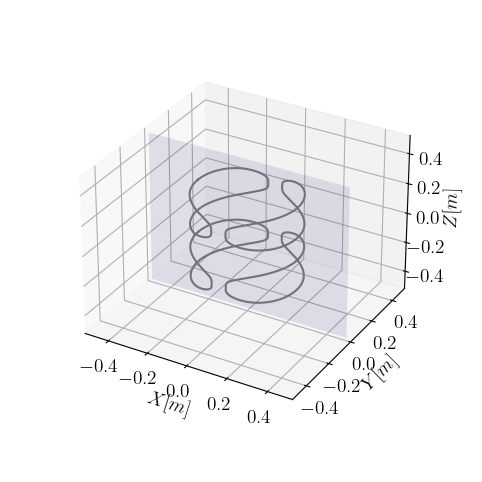

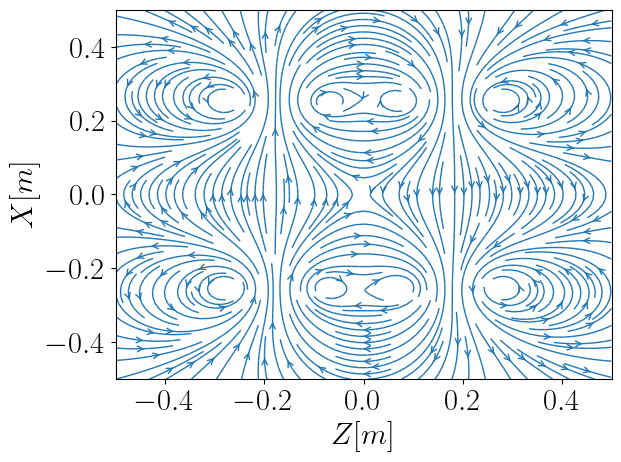

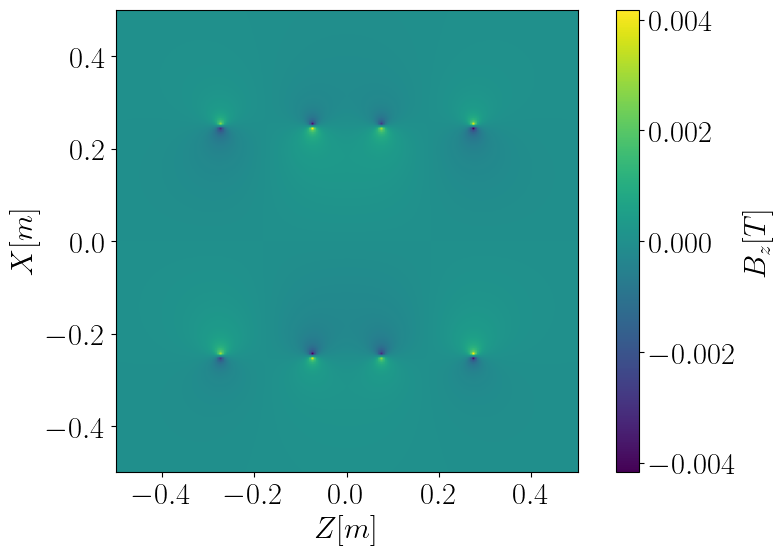

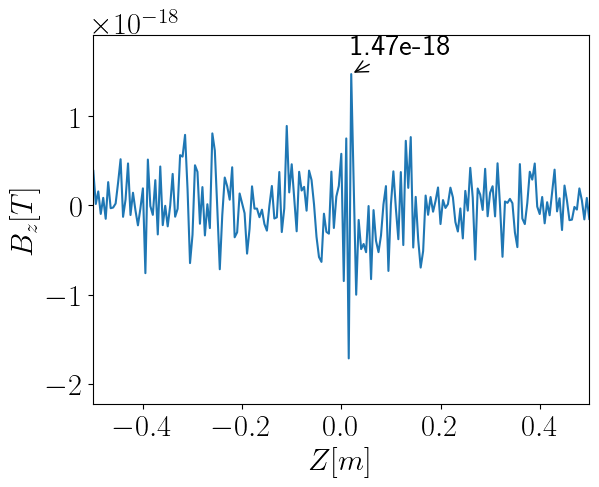

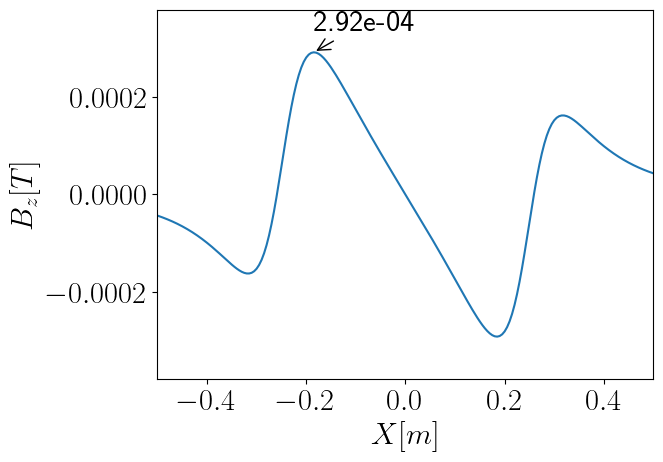

In [5]:
'''
   Variables to change
'''
loop_coverage = 0.10 # Extent of the coil in z
loop_gap = 0.15 # Loop gap of the coil
bore_radius = 0.25 # Diameter of the bore
loop_current = [-100, 100, -100, 100]

# Create 4 loops on the surface of sphere
loop_positionz = [-loop_coverage-loop_gap/2, loop_coverage+loop_gap/2, -loop_coverage-loop_gap/2,  loop_coverage+loop_gap/2]
loop_sign = [ 1, 1, -1, -1]

# Initialize class which will accumulate coils
bs_mag = BSmag()

# Source points
for z, sign, current in zip(loop_positionz, loop_sign, loop_current):
  theta = np.linspace(0, 2*np.pi, 10000)
  N = 4

  zpos = loop_coverage*np.power(np.abs(np.cos(theta)), 2/N)*np.sign(np.cos(theta))+z
  ypos = 0.99*bore_radius*np.power(np.abs(np.sin(theta)), 2/N)*np.sign(np.sin(theta))
  xpos = sign*np.sqrt( bore_radius**2 - ypos**2)

  Gamma = np.column_stack([xpos, ypos, zpos])
  bs_mag.add_filament(Gamma, current)

# Field points
x_M = np.linspace(-0.5, 0.5, 201)
y_M = 0.0
z_M = np.linspace(-0.5, 0.5, 201)
X_M, Y_M, Z_M = np.meshgrid(x_M, y_M, z_M)

# Plot the coils
plot_coils(bs_mag.filament)

# Biot-Savart Integration and plot
X, Y, Z, BX, BY, BZ = bs_mag.get_B(X_M, Y_M, Z_M)
field_plot(X, Y, Z, BX, BY, BZ)